# Machine Learning Tests

## Setup

In [1]:
import mne
import re
import os
import numpy as np
import source_localization as srcl
import MEG_analysis as meg
import machine_learning as ml
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef, Vectorizer)

%matplotlib inline

In [2]:
folder_dict = meg.get_folder_dict()
subj = 'MF-aligned'
meg_dir = '../../../../MEG_raw01/170131_fujita_SD'
should_save_evoked_figs = False
should_train_model = True
source_localization_dir = "/usr/local/freesurfer/subjects"

In [3]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
src, bem = srcl.get_processed_mri_data(subj, source_localization_dir)
cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fwd = srcl.make_forward_sol(evoked, src, bem, "%s/%s-trans.fif" % (meg_dir, subj))

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

## RNN model

### Initialize Train, Test Data

In [4]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [6]:
X = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(-0.1, 0.5, False).bin(0.005).data for i in range(500)]))
X_test = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(-0.1, 0.5, False).bin(0.005).data for i in range(100)]))
del stc_epoch
print(X.shape)

g the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components.

In [4]:
y = []
for i in range(6):
    y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
    y += ml.classify_target_gabors(y_path)  
y = np.array(y)

y_test_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat"
y_test = np.array(ml.classify_target_gabors(y_test_path))

(600,)
[0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1

### Train model with RNN

In [8]:
model = ml.RNNModel(n_epochs=20)
model.fit(X, y)

Epoch 1/20
50/50 [==============================] - 13s 255ms/step - loss: 1.1519 - accuracy: 0.5160
Epoch 2/20
50/50 [==============================] - 13s 253ms/step - loss: 0.7463 - accuracy: 0.5540
Epoch 3/20
50/50 [==============================] - 13s 253ms/step - loss: 0.7408 - accuracy: 0.5900
Epoch 4/20
50/50 [==============================] - 13s 253ms/step - loss: 0.7755 - accuracy: 0.5760
Epoch 5/20
50/50 [==============================] - 13s 255ms/step - loss: 0.5927 - accuracy: 0.6620
Epoch 6/20
50/50 [==============================] - 13s 256ms/step - loss: 0.4835 - accuracy: 0.7900
Epoch 7/20
50/50 [==============================] - 13s 255ms/step - loss: 0.5314 - accuracy: 0.7460
Epoch 8/20
50/50 [==============================] - 13s 254ms/step - loss: 0.4276 - accuracy: 0.8000
Epoch 9/20
50/50 [==============================] - 13s 256ms/step - loss: 0.3832 - accuracy: 0.8080
Epoch 10/20
50/50 [==============================] - 13s 257ms/step - loss: 0.2532 - accura

### Evaluate Performance

In [10]:
model.evaluate(X_test, y_test)
y_pred =model.predict(X_test)
print(y_pred)
y_pred = np.round(y_pred.T[0])
total = 0
for i in range(100):
    if y_pred[i] == y_test[i]:
        total+=1

print(y_pred)
print(total)

4/4 [==============================] - 0s 48ms/step - loss: 3.0936 - accuracy: 0.4400
[[8.67474318e-01]
 [7.68474460e-01]
 [1.41701102e-03]
 [1.05051895e-05]
 [1.60766542e-01]
 [1.44395116e-07]
 [2.87047029e-03]
 [9.76958156e-01]
 [3.46988440e-04]
 [6.45359755e-01]
 [9.88131344e-01]
 [9.98375893e-01]
 [1.89206004e-03]
 [9.99396563e-01]
 [1.92737579e-03]
 [8.73655081e-04]
 [1.41799450e-03]
 [2.74057508e-01]
 [9.99995351e-01]
 [7.58019090e-02]
 [9.62904334e-01]
 [9.90729809e-01]
 [4.68027592e-02]
 [9.98585939e-01]
 [9.99988377e-01]
 [9.07273531e-01]
 [8.05427313e-01]
 [5.34722745e-01]
 [1.44485011e-06]
 [2.15798616e-04]
 [9.99891877e-01]
 [9.67189670e-02]
 [3.90861213e-01]
 [9.99250412e-01]
 [9.91312742e-01]
 [2.07343698e-03]
 [9.86536264e-01]
 [9.45280790e-01]
 [9.43899393e-01]
 [3.32803637e-01]
 [7.33391702e-01]
 [3.83538008e-03]
 [9.99652147e-01]
 [4.25731510e-01]
 [9.68708634e-01]
 [6.82381069e-05]
 [7.24726439e-01]
 [4.89320755e-02]
 [9.99999225e-01]
 [1.39030814e-03]
 [9.99225259e-

## Train mne model

In [4]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [5]:
X = np.array([next(stc_epoch).crop(-0.2, 0.8).bin(0.01).lh_data for i in range(500)])
X_test = np.array([next(stc_epoch).crop(-0.2, 0.8).bin(0.01).lh_data for i in range(100)])
del stc_epoch
print(X.shape)

g the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components.

In [6]:
X.shape

(500, 4098, 100)

In [8]:
y = []
for i in range(5):
    y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
    y += ml.classify_target_gabors(y_path)
y = np.array(y)

y_test_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat"
y_test = np.array(ml.classify_target_gabors(y_test_path))

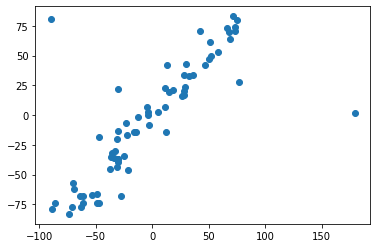

In [10]:
from scipy.io import loadmat

data = loadmat("../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat")
response = data["GabOrSpec"]
target = data["TargetGabor"]

plt.scatter(response, target)

In [11]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=300),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='liblinear')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

#clf.fit(X, y)

#y_pred = clf.predict(X_test)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)



ValueError: x and y must have same first dimension, but have shapes (1501,) and (100,)

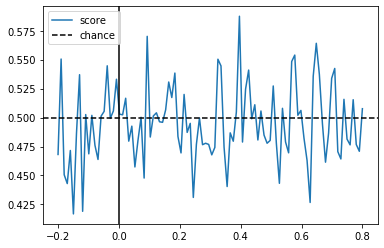

In [12]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(np.linspace(-0.2, 0.8, 100), scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

## Test with just epochs data

In [4]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [6]:
y = []
for i in range(6):
    y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
    y += ml.classify_target_gabors(y_path)
    
y = np.array(y)

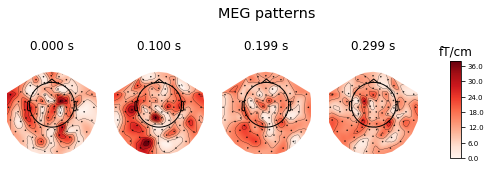

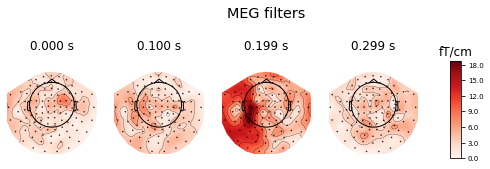

In [7]:
labels = epochs.events[:, -1]
meg_epochs = epochs.copy().pick_types(meg=True, eeg=False).crop(0, 0.3, False)
meg_data = meg_epochs.get_data().reshape(len(labels), -1)
clf = LogisticRegression(solver='lbfgs')
scaler = StandardScaler()

model = LinearModel(clf)

# fit the classifier on MEG data
X = scaler.fit_transform(meg_data)
model.fit(X, y)

for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(meg_epochs.ch_names), -1)

    # Plot
    meg_evoked = mne.EvokedArray(coef, meg_epochs.info, tmin=0)
    meg_evoked.plot_topomap(title='MEG %s' % name, time_unit='s')